# **Mountain Car Problem**

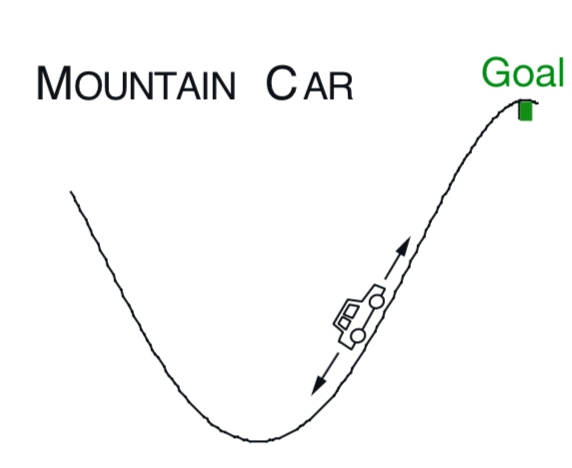

Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram. The difficulty is that gravity is stronger than the car’s engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left.
The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). 

The car moves according to a simplified physics. Its position and velocity, are updated by:


    


*   vel_new = vel + 0.001 * action - 0.0025 * np.cos(3 * pos)

*   pos_new = pos + vel_new



where the bound operation enforces -1.2 <= position <= 0.5 and -0.07 <= velocity <= 0.07. In addition, when position reached the left bound, velocity was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode started from a random position in [-0.6, -0.4] and zero velocity. 

In a nutshell, the car starts at a position between -0.6 and 0.4 with 0 velocity, and it has 3 discrete actions, stay(0), going forward(1) and backward(-1), and the goal is to reach the mountain top at the rightmost. So the states in this problem includes (position, velocity) , action set is (-1, 0, 1) , and reward is -1 everywhere except the goal state(notice that the states are continuous and action is discrete).

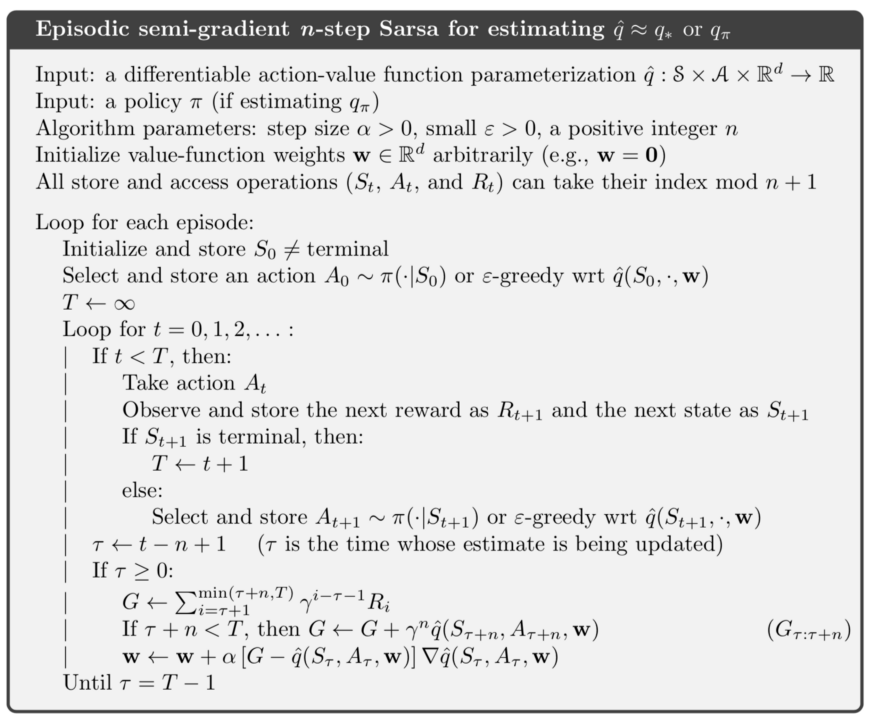

In [3]:
basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if isinstance(m, IHT): return m.getindex(tuple(coordinates), readonly)
    if isinstance(m, int): return basehash(tuple(coordinates)) % m
    if m is None: return coordinates

from math import floor, log
from six.moves import zip_longest

def tiles(ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

Round 500: End at state (0.5, 0.029787077563928913) | number of states 112
Round 1000: End at state (0.5, 0.025830025793005765) | number of states 109
Round 1500: End at state (0.5, 0.02912567784268345) | number of states 113
Round 2000: End at state (0.5, 0.03101522500662407) | number of states 154
Round 2500: End at state (0.5, 0.019760781770611465) | number of states 117
Round 3000: End at state (0.5, 0.015693326118525197) | number of states 116
Round 3500: End at state (0.5, 0.014609846413840647) | number of states 152
Round 4000: End at state (0.5, 0.020820084221960432) | number of states 151
Round 4500: End at state (0.5, 0.0307121324240992) | number of states 182
Round 5000: End at state (0.5, 0.025237235602000616) | number of states 194
Round 5500: End at state (0.5, 0.02680627958271077) | number of states 149
Round 6000: End at state (0.5, 0.021497147416063903) | number of states 115
Round 6500: End at state (0.5, 0.02280475049905765) | number of states 120
Round 7000: End at 

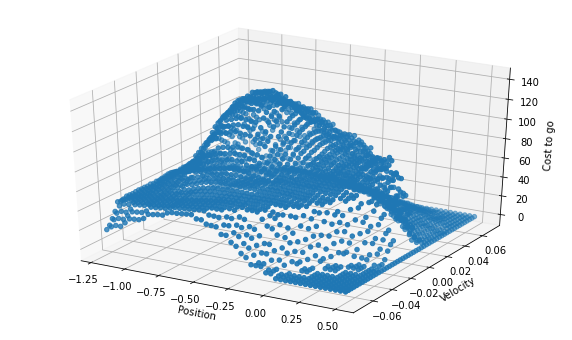

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

VELOCITY_BOUND = [-0.07, 0.07]
POSITION_BOUND = [-1.2, 0.5]
ACTIONS = [-1, 0, 1]


class ValueFunction:

    def __init__(self, stepSize, numOfTilings=8, maxSize=2048):
        self.maxSize = maxSize
        self.numOfTilings = numOfTilings

        # divide step size equally to each tiling, Step size is interpreted as the fraction of the way we want to move towards the target. 
        # To compute the learning rate alpha, scale by number of tilings. 
        self.stepSize = stepSize / numOfTilings 

        # Initialize index hash table (IHT) for tile coding.
        # This assigns a unique index to each tile up to max_size tiles.
        # Ensure max_size >= total number of tiles (num_tilings x tiling_dim x tiling_dim)
        # to ensure no duplicates
        self.hashTable = IHT(maxSize)

        # Initialize weight for each tile
        self.weights = np.zeros(maxSize)

        # Tilecoding software partitions at integer boundaries, so must rescale position and velocity space to span tiling_dim x tiling_dim region.
        # position and velocity needs scaling to satisfy the tile software
        self.positionScale = self.numOfTilings / (POSITION_BOUND[1] - POSITION_BOUND[0])
        self.velocityScale = self.numOfTilings / (VELOCITY_BOUND[1] - VELOCITY_BOUND[0])




    # get indices of active tiles for given state and action ie Returns the featurized representation for a  state-action pair
    def getActiveTiles(self, position, velocity, action):
        activeTiles = tiles(self.hashTable, self.numOfTilings,
                            [self.positionScale * position, self.velocityScale * velocity],
                            [action])
        return activeTiles




    # estimate the value of given state and action, returns the value of current state, and action. When the agent reaches the goal state, returns 0.
    def value(self, position, velocity, action):
        if position == POSITION_BOUND[1]:
            return 0.0
        activeTiles = self.getActiveTiles(position, velocity, action)
        return np.sum(self.weights[activeTiles])




    # learn with given state, action and target - update weights based on the new estimation
    # The idea is that at each update time τ , the accumulated value up to τ+n is used to correct current estimation, and according to gradient descent idea, the parameter weight w is updated slightly towards the actual value proportionally to its derivative and delta.
    def update(self, position, velocity, action, target):
        activeTiles = self.getActiveTiles(position, velocity, action)
        estimation = np.sum(self.weights[activeTiles]) #linear FA
        delta = self.stepSize * (target - estimation)
        for activeTile in activeTiles:
            self.weights[activeTile] += delta



    # used for visualisation, returns the most negative value of that state and action(as the reward is always -1, the result is given a - sign).
    def costToGo(self, position, velocity):
        costs = []
        for action in ACTIONS:
            costs.append(self.value(position, velocity, action))
        return -np.max(costs)


class MountainCar:

    def __init__(self, n=1, exp_rate=0.1, gamma=1, debug=True):
        self.actions = [-1, 0, 1]  # reverse, 0 and forward throttle
        self.state = (-0.5, 0)  # position, velocity
        self.exp_rate = exp_rate
        self.gamma = gamma
        self.end = False
        self.n = n  # step of learning
        self.debug = debug

    def reset(self):
        pos = np.random.uniform(-0.6, -0.4)
        self.end = False
        self.state = (pos, 0)


    # takes in an action and determines next state of the car.
    def takeAction(self, action):
        pos, vel = self.state

        vel_new = vel + 0.001 * action - 0.0025 * np.cos(3 * pos)
        vel_new = min(max(vel_new, VELOCITY_BOUND[0]), VELOCITY_BOUND[1])

        pos_new = pos + vel_new
        pos_new = min(max(pos_new, POSITION_BOUND[0]), POSITION_BOUND[1])

        if pos_new == POSITION_BOUND[0]:
            # reach leftmost, set speed to 0
            vel_new = 0
        self.state = (pos_new, vel_new)
        return self.state


    # uses ϵ-greedy method, and in the greedy part, it chooses the action results in the most estimate value, giving by the valueFunc 
    def chooseAction(self, valueFunc):
        # choose an action based on the current state,
        if np.random.uniform(0, 1) <= self.exp_rate:
            # random action
            return np.random.choice(self.actions)
        else:
            # greedy action
            values = {}
            for a in self.actions:
                pos, vel = self.state
                value = valueFunc.value(pos, vel, a)
                values[a] = value
            return np.random.choice([k for k, v in values.items() if v == max(values.values())])

    def giveReward(self):
        pos, _ = self.state
        if pos == POSITION_BOUND[1]:
            self.end = True
            return 0
        return -1

    def play(self, valueFunction, rounds=1):
        for rnd in range(1, rounds + 1):
            self.reset()
            t = 0
            T = np.inf
            action = self.chooseAction(valueFunction)

            actions = [action]
            states = [self.state]
            rewards = [-1]
            while True:
                if t < T:
                    state = self.takeAction(action)  # next state
                    reward = self.giveReward()  # next state-reward

                    states.append(state)
                    rewards.append(reward)

                    if self.end:
                        if self.debug:
                            if rnd % 500 == 0:
                                print("Round {}: End at state {} | number of states {}".format(rnd, state, len(states)))
                        T = t + 1
                    else: # take next step
                        action = self.chooseAction(valueFunction)
                        actions.append(action)  # next action

                # state tau being updated - specifies state to be updated
                tau = t - self.n + 1
                if tau >= 0:
                  # build target 
                    G = 0
                    for i in range(tau + 1, min(tau + self.n + 1, T + 1)):
                        G += np.power(self.gamma, i - tau - 1) * rewards[i]
                    if tau + self.n < T:
                        state = states[tau + self.n]
                        G += np.power(self.gamma, self.n) * valueFunction.value(state[0], state[1],
                                                                                actions[tau + self.n])
                    # update value function
                    state = states[tau]  # tau is the state to update
                    valueFunction.update(state[0], state[1], actions[tau], G) 


                if tau == T - 1:
                    break

                t += 1


if __name__ == "__main__":
    stepSize = 0.3
    valueFunc = ValueFunction(stepSize)
    mc = MountainCar()
    mc.play(valueFunc, rounds=9000)


    # visualisation: uses the costToGo function defined inside theValueFunction to measure the cost to reach the goal given a state and action
    grids = 50

    positions = np.linspace(POSITION_BOUND[0], POSITION_BOUND[1], grids)
    vels = np.linspace(VELOCITY_BOUND[0], VELOCITY_BOUND[1], grids)

    x = []
    y = []
    z = []
    for p in positions:
        for v in vels:
            x.append(p)
            y.append(v)
            z.append(valueFunc.costToGo(p, v))

    fig = plt.figure(figsize=[10, 6])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)

    ax.set_xlabel("Position")
    ax.set_ylabel("Velocity")
    ax.set_zlabel("Cost to go")

The lower the cost, the closer it is to reach the goal state.

The lower cost appears either at the leftmost position or the rightmost position, which verifies that only by getting to the opposite direction of the goal can the agent be able to reach the final goal state.